# Excercise 2: Pre-processing and data augmentation

![img](http://www.paulvangent.com/files/DL_Course/day2_images/Ex2_intro.jpg)

Is this a male or female? You likely have no trouble recognizing this without effort. But what about a computer, could we teach it to recognize this? Of course we're talking biological, appearance based gender, not how a person chooses to identify. How someone identifies would be practically impossible even for us humans to determine based on a picture alone, let alone for a computer!

----

In this notebook we'll use the above classification task as a guiding example. We'll give you only a little data. The notebook will guide you through the pre-processing you can perform on your dataset prior to applying machine/deep learning. Pre-processing often can increase model performance significantly, and sometimes it is absolutely necessary for your models to learn anything at all.

There is an optional exercise at the end dealing with data augmentation. As we've not given you enough data to learn your model properly, what else can we do? This gives some ideas for what to do when you have little data. Sometimes you can create a 'virtual expansion' of your dataset by augmenting it with variations on existing data. This helps increase your dataset and helps create a more robust model in the end.

You will learn at least:
- Handling variable input sizes (2.1)
- Normalizing or standardizing your data (2.2)
- OPTIONAL: How can you augment your set to improve model performance (and should you)? (2.3)
- OPTIONAL: How do you split your data for training the deep learning model? What do you take into account (2.4)?

Let's get started!

-------------
    
**First, run the cell below to import the required packages we'll be using**

In [1]:
#download required datasets for this notebook (might take a bit, be patient!)
from urllib.request import urlretrieve
import os
from zipfile import ZipFile

def download(url, file):
    if os.path.isfile(file):
        os.remove(file)
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")
        
def unzip(file):
    with ZipFile(file) as f:
        f.extractall()
    print('unzipped file: %s\n' %file)
  
try:
    download('http://www.paulvangent.com/files/DL_Course/celeba_larger.zip', 'celeba_larger.zip')
except:
    download('https://onedrive.live.com/download?cid=39383A5AFCD95065&resid=39383A5AFCD95065%21754594&authkey=AIcRTaFQqi0WnIo', 'celeba_larger.zip')
unzip('celeba_larger.zip')

try:
    download('http://www.paulvangent.com/files/DL_Course/misc_day2.zip', 'misc_day2.zip')
except:
    download('https://onedrive.live.com/download?cid=39383A5AFCD95065&resid=39383A5AFCD95065%21754608&authkey=AOJO5mcV9eCZsJ8', 'misc_day2.zip')
unzip('misc_day2.zip')

try:
    download('http://www.paulvangent.com/files/DL_Course/test_images.zip', 'test_images.zip')
except:
    download('https://onedrive.live.com/download?cid=39383A5AFCD95065&resid=39383A5AFCD95065%21754595&authkey=AETVSL8bPBIpTnI', 'test_images.zip')
unzip('test_images.zip')

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import sys

from PIL import Image
import cv2
from scipy.ndimage import rotate
from keras.datasets import cifar10
from keras.utils import to_categorical
import keras

import utils_day2 as utils

Download file... celeba_larger.zip ...
File downloaded
unzipped file: celeba_larger.zip

Download file... misc_day2.zip ...
File downloaded
unzipped file: misc_day2.zip

Download file... test_images.zip ...
File downloaded
unzipped file: test_images.zip



Using TensorFlow backend.


## 2.1 - Variable input sizes

Usually the first step in any deep learning or machine learning project is getting your data ready. This means pre-processing your data and putting it in the appropriate container.

For these examples we'll use an excerpt of 2000 images from the CelebA dataset, which contains annotations for facial landmarks and a range of attributes, such as whether the person in the image is wearing a hat, has a beard, is attractive, etc.

For example, consider one random female and one random male entry from the set with attached annotated labels, and the annotated bounding box for the face overlaid:

![img](http://www.paulvangent.com/files/DL_Course/day2_images/celeba_1.jpg)
![img](http://www.paulvangent.com/files/DL_Course/day2_images/celeba_2.jpg)

However, before we can start training a model, there is a problem to fix. Every image in the set has different dimensions! While you can make a network work with variable input dimensions, because of the way the data is aggregated and passed through the network during training, at least the dimensions of all images in a given batch needs to be the same.

For now we'll train the network to handle images of a set size, because variable sizes will introduce other caveats that go beyond what we'll be doing today.

---------

**Exercise:**

Resize all images you loaded into memory to 100x100 pixels and put them into the numpy array we initialize below

- Try not to distort the images, think about how you can approach this and break into smaller problems
    
    hint:
    - the largest dimension needs to become 100
    - so you need to compute with what factor you need to multiply the dimensions so that the largest becomes 100 

[resizing hint](https://docs.opencv.org/3.0-alpha/modules/imgproc/doc/geometric_transformations.html?highlight=resize#cv2.resize), note the dimensions need to be integers

Second hint, a visualisation of what you need to do:
![resize and put in container](http://www.paulvangent.com/files/DL_Course/day2_images/Zero-pad.jpg)

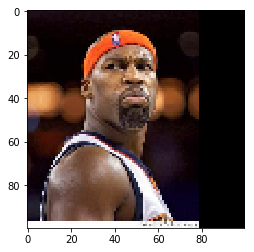

In [0]:
#get the data and labels
labels = pd.read_csv('celeba_larger/labels/annotations.txt')
#files are specified in the annotations
filelist = labels.values[:,0]
Y_data = labels['Male'].values

#first we define a numpy array to hold all image data
X_data= np.zeros(shape=(2000, 100, 100, 3), dtype=np.uint8)

for i in range(len(filelist)):
    img = cv2.imread('celeba_larger/data/%s' %filelist[i])
    
    ###Start of coding segment###
    
    #Complete the code below by following the steps outlined
    #get largest dimension
    largest_dim = np.max(img.shape)
    
    #compute with what factor we need to  multiply both dimensions
    resize_factor = 100 / largest_dim
    
    #compute new dimensions
    x_dim = int(img.shape[0] * resize_factor)
    y_dim = int(img.shape[1] * resize_factor)
    
    #resize image
    img_resized = cv2.resize(img, (y_dim, x_dim))
    
    #put into container
    X_data[i][0:img_resized.shape[0], 0:img_resized.shape[1]] = img_resized
    
    ###End of coding segment###
    
#visualise a random image
plt.imshow(X_data[np.random.randint(0, len(X_data))][...,::-1])
plt.show()

## 2.2 - Normalizing or Standardizing your training data

We can almost start training our network! There is one last thing you usually do before training. In the exercises yesterday after loading the data, the first thing we did was normalize the input values. But why?

Remember from the lecture that for each layer in the network, its input is the output of the previous layer. Each layer will multiply its input with a series of weights, pass it through some activation function, and pass the output to the next layer.

**What do you think, could not normalizing the data be a problem? Why (not)?**

**Would the problem change if we use other data than images?**

-------------
**Exercise**

Let's run a little empirical exercise to warm up and see what happens when not normalizing and when normalizing. Let's try predicting gender from the CelebA subset you loaded and resized.

Complete the cell below to load up the convnet you designed yesterday and compile it.

- use binary crossentropy loss
- use the adamax optimizer


Hint: look at how we compiled the model yesterday, or [have a look at the Keras API](https://keras.io/models/model/#compile)

In [0]:
#load the model
from misc import convnet
model = convnet.build_model(input_shape=(100, 100, 3), classes=1)

#split into training and validation set (more on this in 2.4)
X_train = X_data[0:1800]
X_val = X_data[1800:]

Y_train = Y_data[0:1800]
Y_val = Y_data[1800:]

###Start of coding segment###
#Add your code here (replace '?' with your code)
model.compile(loss='binary_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])

###End of coding segment###

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 47, 47, 64)        16448     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 128)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxP

**Exercise:**

Train the model you just compiled on non-normalized data for 5 epochs and evaluate the model performance. Let's start easy and see if we can teach the model to learn whether the image if male or female.

- Use X_train as training set and Y_train as training labels
- Shuffle the data between epochs
- Make sure to leave 'nonnorm_hist =' in front of the model.fit() call. We'll use this later on to plot progress
- Use X_val and Y_val as validation sets
- 5 epochs should be enough, but feel free to play around!

Hint: look at how you did this yesterday, or [have a look at the Keras API](https://keras.io/models/model/#fit)

In [0]:
#Add your code here (approx 1 line)
nonnorm_hist = model.fit(X_train, Y_train,
                         validation_data=(X_val, Y_val),
                         shuffle=True,
                         epochs=5,
                         batch_size=32)

Instructions for updating:
Use tf.cast instead.
Train on 1800 samples, validate on 200 samples
Epoch 1/5
1800/1800 [==============================] - 11s 6ms/step - loss: 6.6685 - acc: 0.5806 - val_loss: 6.3666 - val_acc: 0.6050
Epoch 2/5
1800/1800 [==============================] - 5s 3ms/step - loss: 6.7786 - acc: 0.5794 - val_loss: 6.3666 - val_acc: 0.6050
Epoch 3/5
1800/1800 [==============================] - 5s 3ms/step - loss: 6.7786 - acc: 0.5794 - val_loss: 6.3666 - val_acc: 0.6050
Epoch 4/5
1800/1800 [==============================] - 5s 3ms/step - loss: 6.7786 - acc: 0.5794 - val_loss: 6.3666 - val_acc: 0.6050
Epoch 5/5
1800/1800 [==============================] - 5s 3ms/step - loss: 6.7786 - acc: 0.5794 - val_loss: 6.3666 - val_acc: 0.6050


- **Take a moment to look at the results. Describe what happened.**
- **Did the model learn anything at all? If so, are you satisfied with the results?**
- **Did the model learn anything at all?**

![img](http://www.paulvangent.com/files/DL_Course/day2_images/XKCD_shufflepile.png)

### Why Normalize your inputs?

Normalizing data can help your model optimizer to converge much better and faster to a global/local minimum. Without normalized inputs this can take a lot longer, or even prove impossible as you have just observed.

Let's confirm this with an empirical test. 

---------

**Exercise**

Complete the cell below with code to normalize the dataset, then run it to observe the behaviour of the same model on normalized data.

- Normalize all image data.
- Use same model compiling parameters.
- Run the model for 10 epochs (we suspect this one *just might* learn something..!).


Train on 1800 samples, validate on 200 samples
Epoch 1/10
1800/1800 [==============================] - 6s 3ms/step - loss: 0.6944 - acc: 0.5661 - val_loss: 0.6889 - val_acc: 0.6050
Epoch 2/10
1800/1800 [==============================] - 5s 3ms/step - loss: 0.6800 - acc: 0.5794 - val_loss: 0.6612 - val_acc: 0.6050
Epoch 3/10
1800/1800 [==============================] - 5s 3ms/step - loss: 0.6598 - acc: 0.5906 - val_loss: 0.6512 - val_acc: 0.6000
Epoch 4/10
1800/1800 [==============================] - 5s 3ms/step - loss: 0.6332 - acc: 0.6461 - val_loss: 0.6002 - val_acc: 0.6450
Epoch 5/10
1800/1800 [==============================] - 5s 3ms/step - loss: 0.6083 - acc: 0.6789 - val_loss: 0.6044 - val_acc: 0.6200
Epoch 6/10
1800/1800 [==============================] - 5s 3ms/step - loss: 0.5877 - acc: 0.6967 - val_loss: 0.5648 - val_acc: 0.6950
Epoch 7/10
1800/1800 [==============================] - 5s 3ms/step - loss: 0.5696 - acc: 0.7072 - val_loss: 0.5845 - val_acc: 0.6950
Epoch 8/10
1800

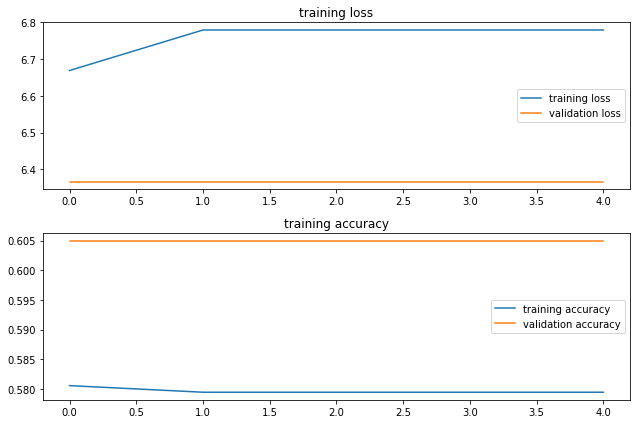

performance of model on normalized data


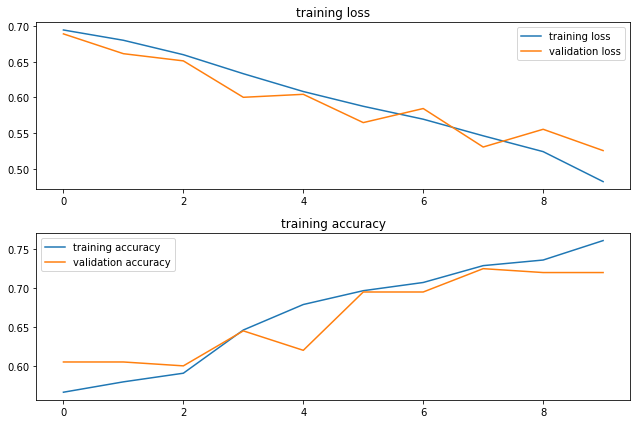

In [0]:
#normalize inputs
#Complete the code below (approx. 2 lines)
X_train_normalized = X_train / 255.
X_val_normalized = X_val / 255.

#Re-initialize a blank model and compile it again
model = convnet.build_model(input_shape=(100, 100, 3), classes=1)

#Complete the code below to compile the model with binary crossentropy loss and adamax optimizer
model.compile(loss='binary_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])

#Complete the code below to fit the model for 10 epochs. Use batch size of 32
norm_hist = model.fit(X_train_normalized, Y_train,
                      validation_data=(X_val_normalized, Y_val),
                      epochs=10,
                      shuffle=True,
                      batch_size=32)

#Let's visualise the losses and accuracies of both sessions
print('\n\n' + ('-=' * 20))
print('performance of model on non-normalized data')
utils.plotter(nonnorm_hist)

print('performance of model on normalized data')
utils.plotter(norm_hist)

**What do you think, is it working well?**

**Can you see signs of overfitting?**

If you think you observe overfitting, or think the model needs to train longer, go back and change the number of epochs to a what you think a good estimate will be.

**Exercise:**

Once you're satisfied with the training result, run the cell below to test the model on a few images.

OPTIONAL: take a picture of yourself and upload to this notebook. On the expandable menu to the right you can upload the image from your computer. Put it in the folder 'test_images', then run the cell below.

If you don't want to test the model on yourself, just run the cell below anyway.

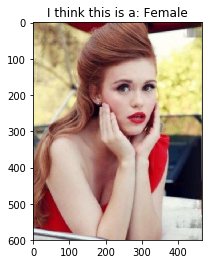

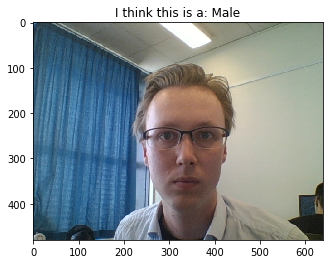

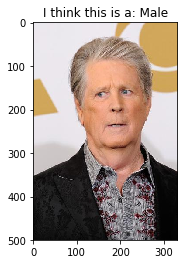

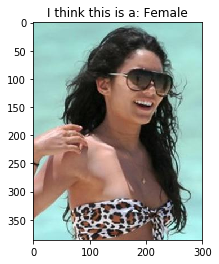

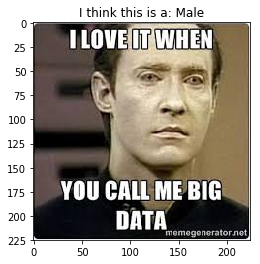

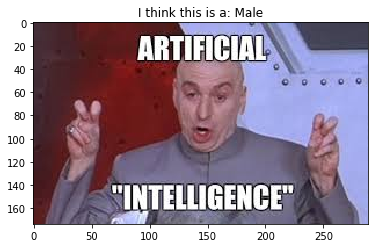

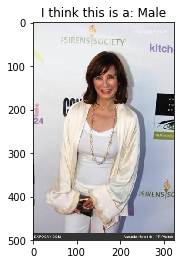

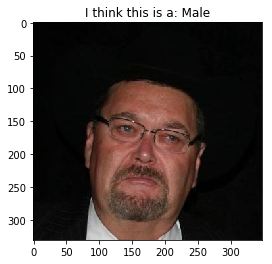

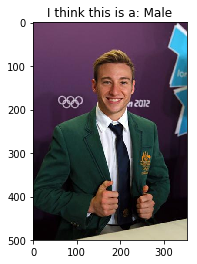

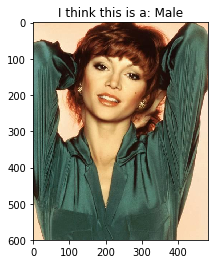

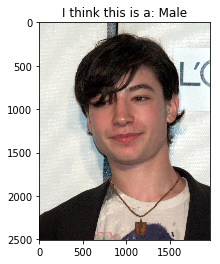

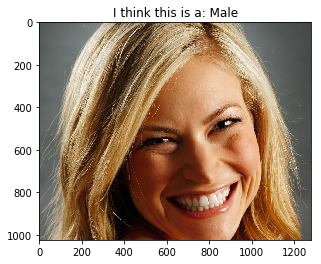

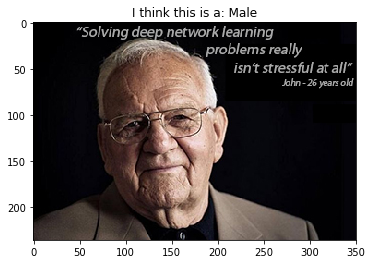

In [0]:
images = glob('test_images/*.jpg')
testdata = utils.prepare_celeba_testdata(max_size=100, c_channels=3)
    
Y = model.predict(np.asarray(testdata))

for prediction, img in zip(Y, images):
    img = cv2.imread(img)
    genders = ['Female', 'Male']
    plt.title('I think this is a: %s' %(genders[int(round(prediction[0]))]))

    plt.imshow(img[...,::-1])
    plt.show()

**Can you explain what you've observed? Why would the behaviour be different with normalized input data?**

If you want, tweak the model parameters such as epochs, loss and optimizer and observe the effects. Can you improve the learning of the model?

### OPTIONAL: Should You Standardize Your Data?

Another pre-processing step you might come across is standardizing the data. This means scaling the data so that it conforms to a gaussian distribution with mean zero and standard deviation of 1. Whether standardizing is appropriate depends on your data, specifically its distribution.

**Can you think of the reason why?**

-------

As with many deep learning problems this is also an empirical one. Test the effects on model performance, does it improve with standardized data? Great, keep it! Note that normalization changes the numeric range without losing information (the distribution remains the same), whereas standardization changes the underlying distribution and can be sensitive to data containing outliers.

**Exercise:**

Standardise the images stored in variable *X_data*, and observe the effects of standardization on performance.

**Hint:** standardization is performed by the formula:

![standardization](http://www.paulvangent.com/files/DL_Course/day2_images/standardization.jpg)


Train on 1800 samples, validate on 200 samples
Epoch 1/10
1800/1800 [==============================] - 7s 4ms/step - loss: 0.7324 - acc: 0.5633 - val_loss: 0.6595 - val_acc: 0.6050
Epoch 2/10
1800/1800 [==============================] - 5s 3ms/step - loss: 0.6668 - acc: 0.6106 - val_loss: 0.6379 - val_acc: 0.6050
Epoch 3/10
1800/1800 [==============================] - 5s 3ms/step - loss: 0.6206 - acc: 0.6672 - val_loss: 0.5901 - val_acc: 0.7050
Epoch 4/10
1800/1800 [==============================] - 5s 3ms/step - loss: 0.5844 - acc: 0.7072 - val_loss: 0.6090 - val_acc: 0.6500
Epoch 5/10
1800/1800 [==============================] - 5s 3ms/step - loss: 0.5505 - acc: 0.7278 - val_loss: 0.5216 - val_acc: 0.7300
Epoch 6/10
1800/1800 [==============================] - 5s 3ms/step - loss: 0.4973 - acc: 0.7444 - val_loss: 0.5144 - val_acc: 0.7950
Epoch 7/10
1800/1800 [==============================] - 5s 3ms/step - loss: 0.4739 - acc: 0.7700 - val_loss: 0.5083 - val_acc: 0.7750
Epoch 8/10
1800

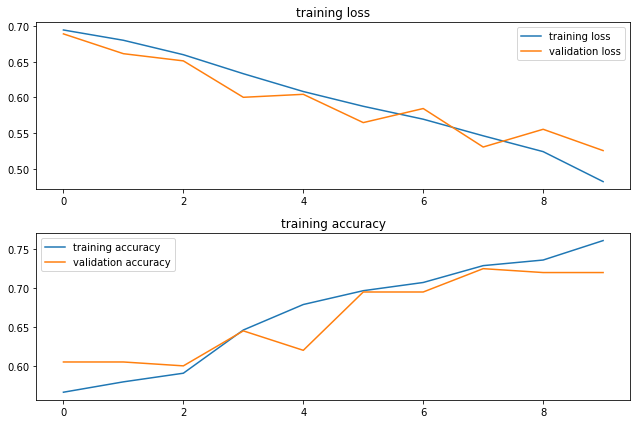

performance of model on standardized data


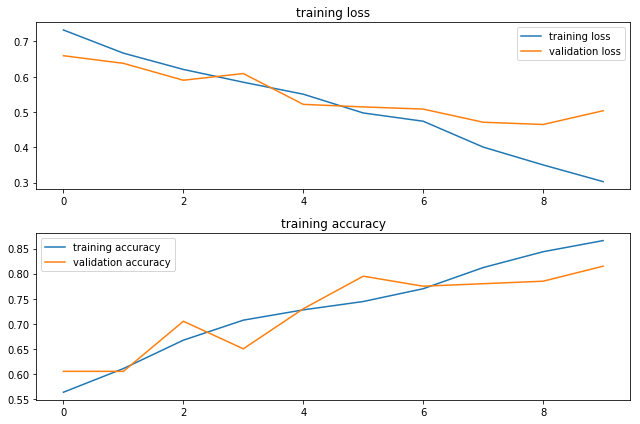

In [0]:
X_standardized = np.zeros((2000, 100, 100, 3), dtype=np.float32)

for i in range(len(X_data)):
    img = X_data[i]
    
    ###Start of coding segment
    #Standardize img
    mean = np.mean(img)
    std = np.std(img)
    
    img_standardized = (img - mean) / std
    ###End of coding segment###

    #We then put the standardized image into the array
    X_standardized[i] = img_standardized

#We initialize an empty model again and compile it
model = convnet.build_model(input_shape=(100, 100, 3), classes=1)
model.compile(loss='binary_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])

#Fit the model
std_hist = model.fit(X_standardized[:1800], Y_train,
                      validation_data=(X_standardized[1800:], Y_val),
                      epochs=10,
                      shuffle=True,
                      batch_size=32)

#Let's visualise the losses and accuracies of both sessions
print('\n\n' + ('-=' * 20))
print('performance of model on normalized data')
utils.plotter(norm_hist)

print('performance of model on standardized data')
utils.plotter(std_hist)

**What do you think, did it help?**

The end-state depends a bit on weight initialization and the path the optimizer takes, but in our case the maximum achieved accuracy was better on one set, whereas the loss was lower for the other set.

**Think about this. Which metric do you trust more? Why?** Ask us if you don't know, this is important!

----------

-----------------

## 2.3 Optional: Data Augmentation

Data augmentation, simply put, is creating extra training examples from your existing data. Consider the following examples of how you can create variations on the same image of a kitten.

![img](http://www.paulvangent.com/files/DL_Course/day2_images/kitten.jpg)

Run the following cell to render some variations on this image. Take notice of what we do numerically.

Download file... kitten.jpg ...
File downloaded


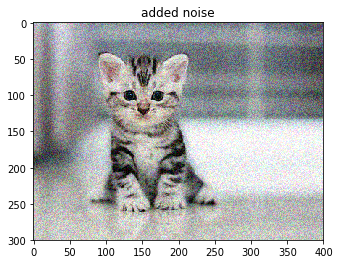

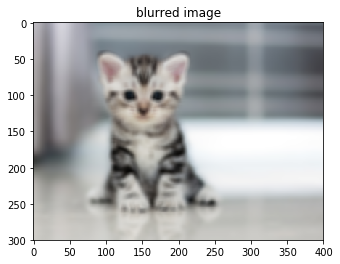

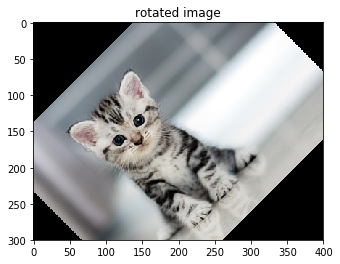

In [0]:
download('http://www.paulvangent.com/files/DL_Course/day2_images/kitten.jpg', 'kitten.jpg')

img = np.array(Image.open('kitten.jpg'))


#Create a noise variant of the image
noise = np.random.randint(-100, 100, size=(img.shape[0], img.shape[1], 3))
#generate noise between 0.25 and 0.75
noise_amount = (0.75 - 0.25) * np.random.random_sample() + 0.25
#add noise to image
noisy_img = np.clip(img + (noise_amount * noise), a_min=0, a_max=255)
plt.title('added noise')
plt.imshow(np.uint8(noisy_img))
plt.show()


#Create a blurred variant of the image
blurred_img = cv2.blur(img, (7,7))
plt.title('blurred image')
plt.imshow(np.uint8(blurred_img))
plt.show()


#Rotate the image 45 degrees counter clockwise
rotated_img = rotate(img, 45, reshape=False)
plt.title('rotated image')
plt.imshow(np.uint8(rotated_img))
plt.show()

### So why would augmentation be useful?

Generally speaking data augmentation can create a more robust model. The reason is that we're increasing the variance in the dataset by transforming or distorting the images. Your model will be forced to learn robust descriptors of the data. For example, by adding a noisy, blurred and rotated version of all images to your set, your model will learn to deal with these transformations.

In many situations you may not have as much training data as you'd like. Using data augmentation in these cases can help your model learn more by providing it with more samples to learn from. 

### How to apply it?
You can write your own that does exactly what you want, which in some cases is preferable. However, Keras has a nice image data generator specifically for images that will do just fine in most situations. [Have a look at the Keras documentation here](https://keras.io/preprocessing/image/).

**Exercise:**

Apply the image data generator to the *X_train_normalized* and *X_val_normalized* set in memory, and train a model. Look at the keras documentation for hints and examples.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

###Start of coding segment###
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=(0,0.3))
###End of coding segment###


model = convnet.build_model(input_shape=(100, 100, 3), classes=1)
model.compile(loss='binary_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])

###Start of coding segment###
model.fit_generator(datagen.flow(X_train_normalized, Y_train, batch_size=32),
                    steps_per_epoch=1800 // 32,
                    epochs=10,
                    validation_data=(datagen.flow(X_val_normalized, Y_val, batch_size=10)),
                    validation_steps = 200 // 10)
###End of coding segment###

Epoch 1/10
56/56 [==============================] - 10s 175ms/step - loss: 3.0875 - acc: 0.5407 - val_loss: 0.7185 - val_acc: 0.4600
Epoch 2/10
56/56 [==============================] - 8s 140ms/step - loss: 0.6861 - acc: 0.5725 - val_loss: 0.6760 - val_acc: 0.6550
Epoch 3/10
56/56 [==============================] - 8s 139ms/step - loss: 0.6680 - acc: 0.6054 - val_loss: 0.6613 - val_acc: 0.6350
Epoch 4/10
56/56 [==============================] - 8s 140ms/step - loss: 0.6535 - acc: 0.6222 - val_loss: 0.6511 - val_acc: 0.6250
Epoch 5/10
56/56 [==============================] - 8s 142ms/step - loss: 0.6708 - acc: 0.6048 - val_loss: 0.6345 - val_acc: 0.6350
Epoch 6/10
56/56 [==============================] - 8s 141ms/step - loss: 0.6622 - acc: 0.6066 - val_loss: 0.6448 - val_acc: 0.6300
Epoch 7/10
56/56 [==============================] - 8s 140ms/step - loss: 0.6443 - acc: 0.6300 - val_loss: 0.6250 - val_acc: 0.5950
Epoch 8/10
56/56 [==============================] - 8s 140ms/step - loss: 0

### Should you apply it?
The main consideration for augmenting your dataset should be whether it increases performance. What do you want to predict? What are the boundary conditions of the data your model will encounter 'in the wild'? 

Say you want to predict someone's age from pictures of faces. If all the model will ever see at runtime is pictures with faces centered and horizontally aligned, adding rotated images to your training set makes little sense. 

The downside is your model needs to fit a more complex function to make predictions, which means you might need a bigger model that takes more memory and more time to compute. Think about what you want to achieve with it before choosing to augment your set or not.

**Too much augmentation can also cause underfitting (as you've problably observed)!**

-----------

## 2.4 OPTIONAL: Splitting Your Data Into Appropriate Sets

Remember from yesterday that it's common practice to split your dataset into a *training set*, *validation set* and *test set*. You use your *training set* to teach the model something, and monitor for signs of overfitting and other potential trouble by using the *validation set*. Once you finish tweaking the model and training, you use the last *test* holdout set to validate that the model indeed performs as you expect. How big should each set be? There is no magic number for this, but luckily there are some common sense rules of thumb we can follow.

For machine learning problems, where the datasets are usually a lot smaller, the [pareto principle](https://en.wikipedia.org/wiki/Pareto_principle) is often used, splitting the data 80/20 (train/test). For train/val/test sets a common distribution used to be 60/20/20 (train/val/test).

This is reasonable, as you need sufficient examples to evaluate the model's performance. For example, a common toy dataset used in machine learning is the [Iris dataset](https://scikit-learn.org/0.16/modules/generated/sklearn.datasets.load_iris.html) that contains data on how petal shapes of three iris plants relate to their species.

![img](http://www.paulvangent.com/files/DL_Course/day2_images/220px-Iris_versicolor_3.jpg)

With this set, one valid distribution could be 120 samples for training and 30 samples for testing, which gives the model enough data to learn from, and enough data for us to understand the performance. Testing a model on one or two examples will never give a good performance indication. 

**Can you explain why?**

-------------

### Moving to Deep Learning

With deep learning the data sets are usually **a lot** larger. 

![img](http://www.paulvangent.com/files/DL_Course/day2_images/bigdata.jpg)

There is no need to keep to the 80/20 or 60/20/20 conventions. This will create an unnecessarily large validation and test set, and more importantly, it deprives your model of a lot of training data. As a result, it might learn less than it otherwise would.

The bottom line is: set your validation and test sets to be large enough to give you enough confidence in the performance of your model.

For example, given a dataset of 1.000.000 examples, even a test set of 1% will give you 10.000 examples. This might very well be enough.

### Splitting smart

A particularly important consideration is not how large the split in your dataset is, but *how* you make the split. Consider you want to train a model to recognize cyclists and pedestrians. The first 10.000 images in your dataset are cyclists, the second 10.000 are pedestrians. You take the first 18.000 images (90%) to train your model. 1000(5%) are used for validation, and the last 1000 for testing. After training you find out:

- Performance on both the validation and test set is excellent (let's say 98.5% correct rate).
- When you test the system in real life, it turns out to not detect cyclists very well.

**What could be the problem here? Why didn't we catch this poor performance?**

**How would you solve this?**

---------

As you might have guessed from the example given, it is important that our validation and test sets are representative of the problem we want to solve. In the given example we only tested the model on pedestrian data since the set was ordered. This caused us to miss poor performance on detecting cyclists. This is important to check: many datasets are ordered by class. To solve this we simply shuffle the data before splitting it.

**Exercise:**

Shuffle the data below. [hint](https://pynative.com/python-random-shuffle/)

- Take note: you need to shuffle both the data and the labels the same way, or you'll lose the mapping between input and output data.

[the manual way hint](https://stackoverflow.com/a/23289591)

[the easy way hint](https://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html)

170500096/170498071 [==============================] - 40s 0us/step


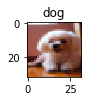

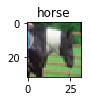

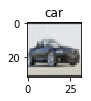

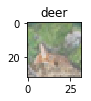

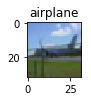

In [0]:
import random
#first we load the cifar10 data again
(X_train, Y_train), (_, _) = cifar10.load_data()


#Complete the code below to shuffle the lists (approx X lines)
#Take a look above at both ways to shuffle. Pick one and write the code.
combined = list(zip(X_train, Y_train))
random.shuffle(combined)
X_train, Y_train = zip(*combined)

#OR#

from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train)

###End of coding segment###

#let's test a few random entries in your shuffled data
#the labels in the output should match the pictures if you did it correctly
for i in np.random.randint(0, len(X_train), size=(5,)):
    plt.figure(figsize=(1,1))
    plt.imshow(X_train[i])
    plt.title(utils.c10_labels[int(Y_train[i])])
    plt.show()

The Keras .fit() function has a 'shuffle' flag. You can use this from now on, but now you know how to do it manually in case you need to shuffle your dataset before splitting into train/val/test sets.